In [1]:
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.models import load_model
import numpy as np
import pickle
import cv2
import os
import matplotlib.pyplot as plt
from sklearn import metrics
import random
from pathlib import PurePosixPath
import pandas as pd

In [2]:
model_path = "output_1/detector.h5"
binarizer_path = "output_1/lb.pickle"
model = load_model(model_path)
lb = pickle.loads(open(binarizer_path, "rb").read())

f = open("output_1/test_paths.txt", "r")
imagePaths = list(f)
imagePaths = [each.strip("\n").replace(",","") for each in imagePaths] # need to fix this shit

f = open("output_1/test_labels.txt", "r")
imageLabs = list(f)
imageLabs = [each.strip("\n").replace(",","") for each in imageLabs] # and this shit

/opt/anaconda3/lib/python3.7/site-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator LabelBinarizer from version 0.23.2 when using version 0.22.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


In [3]:
# True labels
y_true = []
for image in imageLabs:
    img = np.array([int(i) for i in image]) # need to fix this lmao so inefficient
    img = img.reshape(1,8)
    index = np.argmax(img, axis=1)
    label = lb.classes_[index][0]
    y_true.append(label)

In [6]:
%%time
# True bounding boxes
# 23s for 1600 values
Annots = pd.read_csv("Annotations_8catags2.csv").drop("Unnamed: 0",axis=1)
def get_bboxes(imgpath):
    p = PurePosixPath(imgpath)
    img = str(p.relative_to("DeepFashion")) # another data mismatch - maybe i'll fix it someday 
    x1,x2,y1,y2 = Annots.loc[Annots['Image'] ==img].values[0][2:] # trace bboxes from Annotations file
    return (x1,x2,y1,y2) # change to (x1,y1,x2,y2) after training the new model

bboxes_true = []
for path in imagePaths:
    x1,y1,x2,y2 = get_bboxes(path)
    bboxes_true.append((x1,y1,x2,y2))

CPU times: user 23.6 s, sys: 92.8 ms, total: 23.7 s
Wall time: 23.8 s


In [8]:
%%time
# Predicted labels and bounding boxes
# takes ~5 mins for 1600 values - no time savings by reading images only with cv2.
bboxes_pred = []
y_pred = []
for img in imagePaths:
    image = load_img(img, target_size=(224, 224))
    image = img_to_array(image) / 255.0
    image = np.expand_dims(image, axis=0)
    (boxPreds, labelPreds) = model.predict(image)
    (x1, y1, x2, y2) = boxPreds.flatten()
    image = cv2.imread(img)
    (h, w) = image.shape[:2]
    # re-scale the bounding box coordinates to fit the original image
    x1 = int(x1 * w)
    y1 = int(y1 * h)
    x2 = int(x2 * w)
    y2 = int(y2 * h)
    bboxes_pred.append((x1, y1, x2, y2))
    index = np.argmax(labelPreds, axis=1)
    label = lb.classes_[index][0]
    y_pred.append(label)

CPU times: user 21min 34s, sys: 56 s, total: 22min 30s
Wall time: 4min 26s


In [9]:
print(metrics.confusion_matrix(y_true,y_pred,labels=lb.classes_))

[[113  12   5   9   3   9  16  10]
 [ 30 111   2  15  12   2   2  24]
 [  4   4  82  52   2   8   4  37]
 [ 12   8  25 106   3   7   3  39]
 [ 20 115   3  15  11   4   3  39]
 [ 32  10   3   6   2 149   7  10]
 [ 32  11   2   6   1  16 102  25]
 [ 10  15   8  29   4   6  13 120]]


In [10]:
print(metrics.classification_report(y_true, y_pred,labels=lb.classes_))

              precision    recall  f1-score   support

     Bottoms       0.45      0.64      0.53       177
       Dress       0.39      0.56      0.46       198
      Hoodie       0.63      0.42      0.51       193
      Jacket       0.45      0.52      0.48       203
    Jumpsuit       0.29      0.05      0.09       210
        Pant       0.74      0.68      0.71       219
      Shorts       0.68      0.52      0.59       195
         Top       0.39      0.59      0.47       205

    accuracy                           0.50      1600
   macro avg       0.50      0.50      0.48      1600
weighted avg       0.50      0.50      0.48      1600



In [11]:
def plot_bboxes(imagepath,true_bbox,pred_bbox):
    x1,x2,y1,y2 = true_bbox
    rx1,rx2,ry1,ry2 = pred_bbox
    img2 = cv2.imread(imagepath)
    img2 = cv2.cvtColor(img2, cv2.COLOR_BGR2RGB)
    copy = img2.copy()
    plt.imshow(cv2.rectangle(copy,(x1,y1),(x2,y2),(36,255,12),2)) # actual - green
    plt.imshow(cv2.rectangle(copy,(rx1,ry1),(rx2,ry2),(255,36,12),2)) #predicted - red
    plt.show()

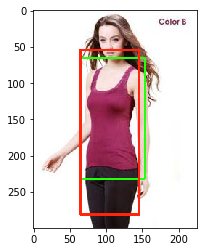

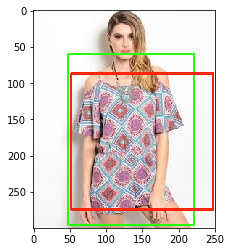

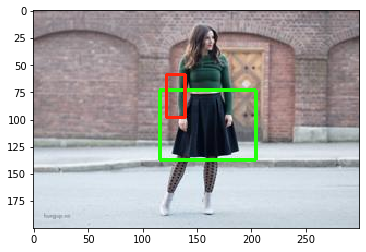

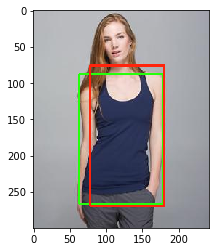

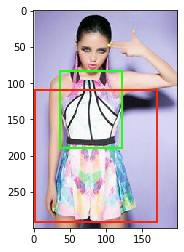

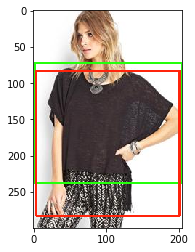

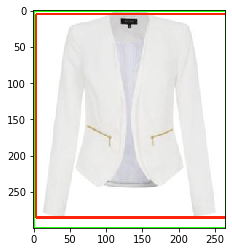

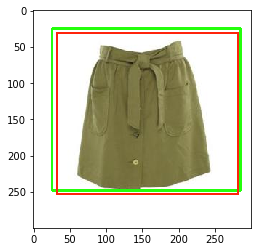

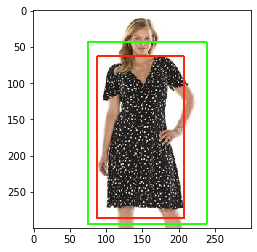

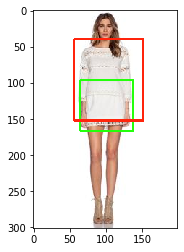

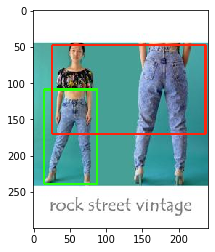

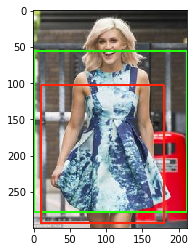

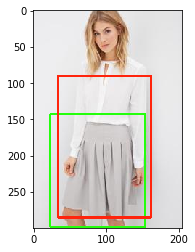

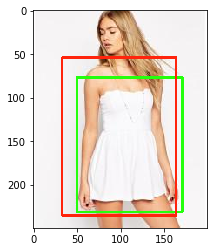

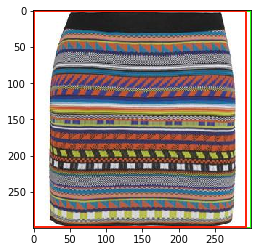

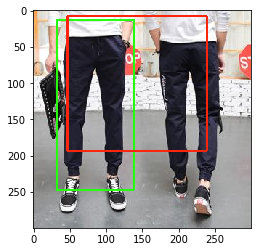

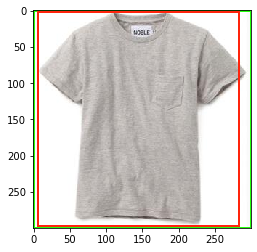

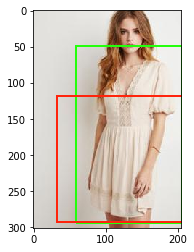

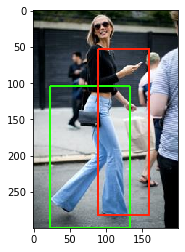

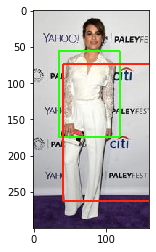

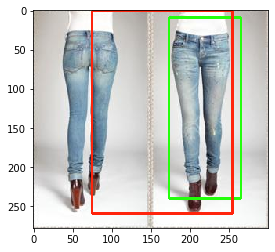

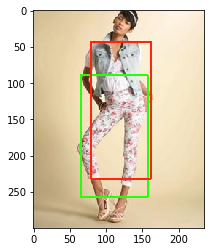

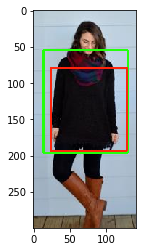

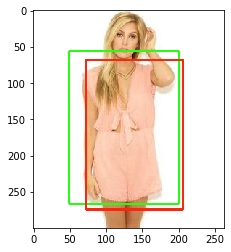

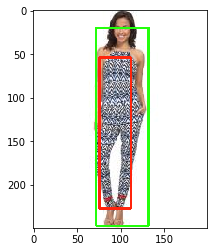

In [12]:
randomlist = random.sample(range(0, 1600), 25)
for i in (randomlist):
    true_bbox = bboxes_true[i]
    pred_bbox = bboxes_pred[i]
    img = imagePaths[i]
    plot_bboxes(img,true_bbox,pred_bbox)